# Tugas Besar IF3270 Pembelajaran Mesin Bag.A

Anggota Kelompok:
1. 13520039 - Rozan Fadhil Al Hafidz
1. 13520054 - Farrel Farandieka Fibriyanto
1. 13520103 - Amar Fadil
1. 13520105 - Malik Akbar Hashemi Rafsanjani

## Teori Dasar

### FFNN
Atau Feed Forward Neural Network merupakan jenis model artificial neural network yang tidak mengandung siklus dan termasuk model yang paling sederhana karena memproses informasi ke satu arah saja.

![Sample-of-a-feed-forward-neural-network.png](https://www.researchgate.net/profile/Ramon-Quiza/publication/234055177/figure/fig1/AS:300092981563410@1448559150651/Sample-of-a-feed-forward-neural-network.png)

Sumber: [Quiza, R.](https://www.researchgate.net/figure/Sample-of-a-feed-forward-neural-network_fig1_234055177)

Terdapat 3 layer dalam ilustrasi di atas:
1. Input Layer:
    - layer yang menerima input atau fitur dari data
2. Hidden Layer:
    - layer yang berada diantara input dan output layer
    - layer yang melakukan proses pembelajaran mesin melalui forward propagation serta activation function
    - Bisa memiliki lebih dari satu layer
    - Tidak terlihat saat proses pembelajaran
3. Output Layer
    - layer yang menghasilkan output dari data
    - Jumlah neuron di output layer sama dengan jumlah kelas yang akan diprediksi

### Activation Function
Fungsi Aktivasi biasanya dipakai dalam arsitektur ketika terjadi perpindahan layer, sebelum nilai output diberikan ke layer berikutnya akan dilalui fungsi aktivasi terlebih dahulu. Fungsi aktivasi ini biasanya digunakan untuk menambahkan sifat non-linearitas pada neural network. 

## Import Libraries

In [66]:
import numpy as np
from typing import Callable
import json
import networkx as nx
import matplotlib.pyplot as plt


## Initiate Program

Kelas activations akan menyimpan fungsi aktivasi yang dapat dipakai oleh kelas neuron

In [67]:
class activations:
    def softmax(x):
        return np.exp(x)  

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def relu(x):
        return np.maximum(0, x)

    def sign(x):
        return 1 if x > 0 else -1

    def linear(x):
        return x

Kelas JsonReader bertanggung jawab untuk membaca fail json yang menyimpan kriteria model dengan format yang kami tetapkan sendiri. Dengan kelas ini, program dapat me-load model-model yang telah ditetapkan di fail json eksternal

In [68]:
class JsonReader:
    def __init__(self, filename: str):
        self.filename = filename
        self.data = None

    def read(self):
        with open(self.filename, 'r') as f:
            self.data = json.load(f)

    def get(self, index: int):
        return self.data[index]

    def length(self):
        return len(self.data)

Terdapat 3 kelas utama yang akan digunakan dalam implementasi: Model, Layer, dan Neuron. 
Ketiga kelas akan bersifat dengan entitas dengan nama yang sama seperti di arsitektur neural network biasanya. Suatu fungsi aktivasi akan disimpan di daftar fungsi aktivasi sehingga dapat di-invoke oleh kelas neuron.

Kelas neuron akan menyimpan weight yang telah ditetapkan sebelumnya dan menghitung nilai output berdasarkan nilai weight tadi, sebuah fungsi aktivasi, dan nilai masukan yang berasal dari masukan model seluruhnya atau hasil output layer sebelumnya di model.

Kelas layer akan menyimpan beberapa kelas neuron sehingga membentuk suatu layer penuh. Kelas ini juga dapat menghasilkan array berupa output neuron yang dimiliki kelas tersebut. Dengan ini, kelas ini bisa menghasilkan nilai yang akan dapat dijadikan masukan layer berikutnya atau, apabila sudah merupakan layer terakhir, menjadi output dari model seluruhnya.

Kelas model akan menyimpan beberapa kelas layer yang dapat dipakai untuk menghitung perhitungan prediksi model tersebut. Kelas model akan menerima nilai masukan dari pengguna dan kemudian mengiterasi dari layer paling awal untuk menghitung nilai keluaran dari layer tersebut untuk kemudian dijadikan parameter untuk layer berikutnya, dan seterusnya sampai sampai ke layer terakhir.

In [69]:
class Neuron(object):
    def __init__(
        self,
        activation: Callable | str = 'sigmoid',
        weights: list[float] = None,
    ):
        self.activation = activation
        if isinstance(activation, str):
            self.activation: Callable = getattr(activations, activation)
        self.weights = weights
        self.value = 0

    def __call__(self, x: list[float]):
        # feed forward
        val = np.dot(x, self.weights)
        self.value = self.activation(val)
        return self.value

    def __repr__(self):
        return f'Neuron({self.activation.__name__}, {self.weights})'


class Layer(object):
    def __init__(
        self,
        neurons: list[Neuron] | int,
        name: str = '',
        activation: Callable | str = '',
        weights: list[list[float]] = None,
        bias: float = 1,
        input_shape=0,
    ) -> None:
        self.name = name
        self.activation = activation
        if isinstance(activation, str):
            self.activation: Callable = getattr(activations, activation)
        self.neurons = neurons
        if isinstance(neurons, int):
            self.neurons: list[Neuron] = [
                Neuron(activation, weights[i] if weights else 0)
                for i in range(neurons)
            ]
        self.bias = bias
        self.input_shape = input_shape

    def get_output_shape(self):
        return len(self.neurons)

    def get_params_count(self):
        return (len(self.neurons) + 1) * self.input_shape

    def get_weights(self):
        return np.array([neuron.weights for neuron in self.neurons])

    def __call__(self, inputs: list[float]) -> list[float]:
        # feed forward
        out = [neuron(inputs) for neuron in self.neurons]
        if self.activation is activations.softmax:
            out = (out / sum(out)).tolist()
        return out

    def __repr__(self):
        activation_name = self.activation.__name__
        weights = self.get_weights()
        param_count = (len(weights) + 1) * self.input_shape

        return ''.join([
            'Layer(',
            f'activation={activation_name},',
            f'weights={weights},',
            f'bias={self.bias},',
            f'param_count={param_count}',
            ')',
        ])


class Model(object):
    def __init__(self, layers: list[Layer] = None) -> None:
        self.layers = layers
        if layers is None:
            self.layers: list[Layer] = []

    def add(self, layer: Layer) -> None:
        if self.layers:
            layer.input_shape = self.layers[-1].get_output_shape()
        self.layers.append(layer)

    def get_params_count(self):
        return sum([layer.get_params_count() for layer in self.layers])

    def summary(self):
        print(f'Model with {self.get_params_count()} parameters')
        for layer in self.layers:
            print(layer)

    def draw(self):
        graph = nx.DiGraph()

        # draw input layer
        num_neurons = len(self.layers[0].neurons[0].weights) -1
        print("num_neurons", num_neurons)

        for i in range(num_neurons):
            graph.add_node(f"-1-{i}", pos=(-1, i))


        for i, layer in enumerate(self.layers):
            for j, neuron in enumerate(layer.neurons):
                graph.add_node(f"{i}-{j}", pos=(i, j))

                for k, weight in enumerate(neuron.weights):
                    if k == len(neuron.weights) - 1:
                        continue

                    graph.add_edge(f"{i-1}-{k}", f"{i}-{j}", weight=weight)


        # for i, layer in enumerate(self.layers):
        #     for j, neuron in enumerate(layer.neurons):
        #         count = 0

        #         graph.add_node(f"{i}-{j}", pos=(i, j))
        #         print("neuron.weights",)
        #         for k, weight in enumerate(neuron.weights):
        #             graph.add_edge(f"{i-1}-{k}", f"{i}-{j}", weight=weight)
        #             count += 1
        #         graph.add_edge(f"{i-1}-{count}", f"{i}-{j}", weight=layer.bias)

        pos = nx.get_node_attributes(graph, 'pos')
        nx.draw(graph, pos, with_labels=True)
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        plt.show()

    def __call__(self, inputs: list[list[float]]):
        # feed forward
        outputs: list[list[float]] = []
        for input in inputs:
            out = input
            for layer in self.layers:
                out.append(1)
                out = layer(out)
            outputs.append(out)
        
        return outputs

Kelas ModelFactory akan membuat model-model yang dapat dipakai secara langsung. Kelas ini dapat menerima masukan suatu nama fail ketika di-invoke dan akan mengembalikan model yang telah dibuat sesuai dengan kriteria yang telah ditetapkan di fail json eksternal tersebut.

In [70]:
class ModelFactory:
    def __init__(self, model_name):
        self.model_name = model_name
        self.json_reader = JsonReader(f'{model_name}.json')
        self.model = None

    def create(self) -> Model:
        self.json_reader.read()
        self.model = Model()
        for i in range(self.json_reader.length()):
            layer = self.json_reader.get(i)
            self.model.add(Layer(
                layer['neurons'],
                input_shape=layer['neurons'] + 1,
                activation=layer['activation'],
                weights=layer['weights'],
                bias=layer['bias'],
            ))
        return self.model

Kelas ModelTester merupakan kelas yang membantu untuk melakukan pengetesan terhadap hasil model yang telah dibuat. Kelas ini akan menerima masukan berupa model yang akan diuji, data yang akan diuji, dan label yang akan diuji. Kelas ini akan menghitung akurasi dari model yang telah dibuat menggunakan nilai SSE

In [71]:
class ModelTester:
    def __init__(self, max_sse: float = 0.000001):
        self.max_sse = max_sse
    
    def calculate_sse(
        self, 
        predicted_result: list[list[float]], 
        expected_result: list[list[float]]) -> float:
        return sum([sum([(predicted_result[i][j] - expected_result[i][j]) ** 2 for j in range(len(predicted_result[i]))]) for i in range(len(predicted_result))])

    def test(self, predicted_result: list[list[float]], expected_result: list[list[float]]) -> bool:
        sse = self.calculate_sse(predicted_result, expected_result)
        print(f'SSE: {sse}')
        print(f'Max SSE: {self.max_sse}')
        print(f'Is SSE less than max SSE? {sse < self.max_sse}')

## Pengujian

In [72]:
tester = ModelTester(0.000001)

#### Relu

Model with 16 parameters
Layer(activation=relu,weights=[[ 0.4  0.7  0.1]
 [-0.5  0.8  0.2]
 [ 0.6 -0.9  0.3]],bias=1,param_count=16)
num_neurons 2


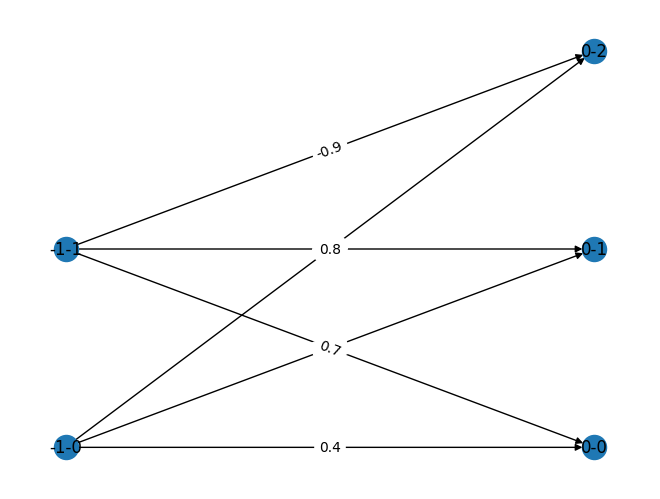


Predicted Data: [[0.04999999999999996, 1.1, 0.0]]
SSE: 1.7333369499485123e-33
Max SSE: 1e-06
Is SSE less than max SSE? True


In [73]:
model_name = 'test/relu'

model_factory = ModelFactory(model_name)
model = model_factory.create()
model.summary()
model.draw()
print()

data = [[-1.0, 0.5]]
expected_output = [[0.05, 1.1, 0.0]]
trained = model(data)
print(f'Predicted Data: {trained}')

tester.test(trained, expected_output)

#### Sigmoid

Model with 16 parameters
Layer(activation=sigmoid,weights=[[0.2 0.1 0.4]
 [0.4 0.2 0.2]
 [0.2 0.4 0.1]],bias=1,param_count=16)
num_neurons 2


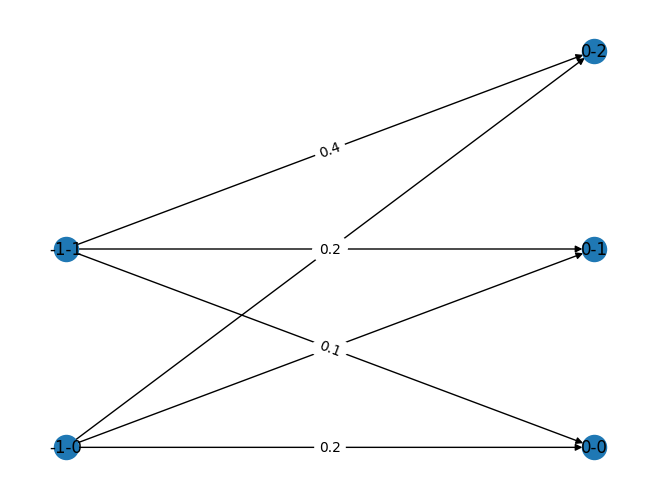


Predicted Data: [[0.617747874769249, 0.5890404340586651, 0.574442516811659]]
SSE: 1.2207224545374987e-12
Max SSE: 1e-06
Is SSE less than max SSE? True


In [74]:
model_name = 'test/sigmoid'

model_factory = ModelFactory(model_name)
model = model_factory.create()
model.summary()
model.draw()
print()

data = [[0.2, 0.4]]
expected_output = [[0.617747, 0.589040, 0.574442]]
trained = model(data)
print(f'Predicted Data: {trained}')

tester.test(expected_output, trained)

#### Linear

Model with 16 parameters
Layer(activation=linear,weights=[[ 0.5  0.3  0.2]
 [ 0.2 -0.6  0.3]
 [-0.8  0.4  0.1]],bias=1,param_count=16)
num_neurons 2


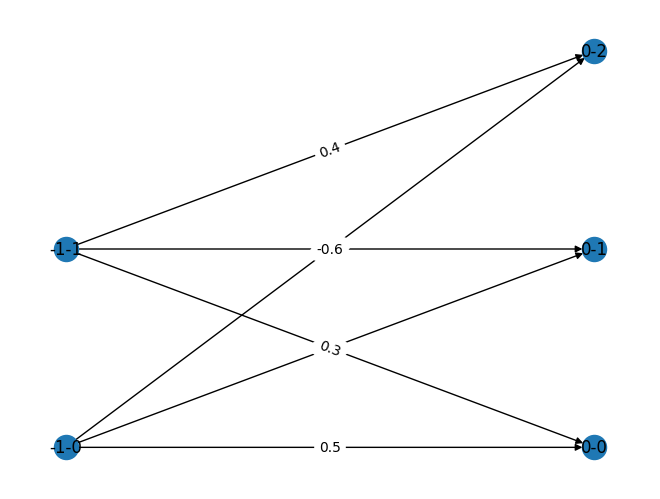


Predicted Data: [[2.0, 0.3000000000000001, -1.9000000000000004]]
SSE: 2.0954117794933126e-31
Max SSE: 1e-06
Is SSE less than max SSE? True


In [75]:
model_name = 'test/linear'

model_factory = ModelFactory(model_name)
model = model_factory.create()
model.summary()
model.draw()
print()

data = [[3.0, 1.0]]
expected_output = [[ 2.0,  0.3, -1.9]]
trained = model(data)
print(f'Predicted Data: {trained}')

tester.test(expected_output, trained)

#### MultiLayer

Model with 15 parameters
Layer(activation=linear,weights=[[ 0.  -1.   0.5]
 [-2.   0.   0.5]],bias=1,param_count=9)
Layer(activation=relu,weights=[[ 0.  -1.   0.5]
 [-3.   0.   0.5]],bias=1,param_count=6)
num_neurons 2


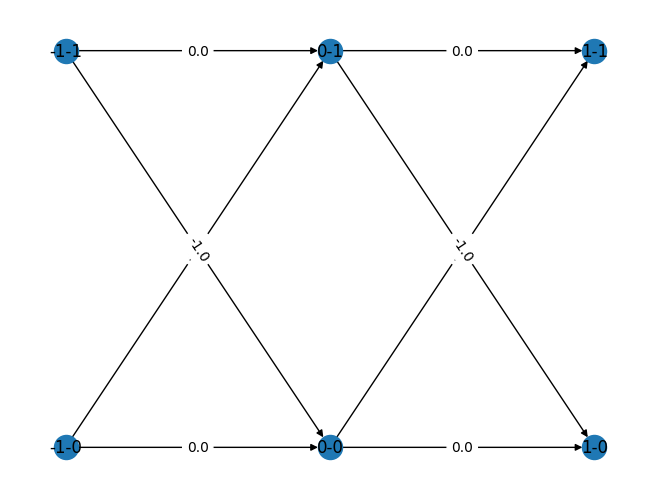


Predicted Data: [[2.0, 0.0], [0.0, 2.0], [0.0, 0.0]]
SSE: 0.0
Max SSE: 1e-06
Is SSE less than max SSE? True


In [76]:
model_name = 'test/multilayer'

model_factory = ModelFactory(model_name)
model = model_factory.create()
model.summary()
model.draw()
print()

data = [
            [1.0, 0.0],
            [0.0, 1.0],
            [0.0, 0.0]
        ]
expected_output = [
            [2.0, 0.0],
            [0.0, 2.0],
            [0.0, 0.0]
        ]
trained = model(data)
print(f'Predicted Data: {trained}')

tester.test(expected_output, trained)

#### Softmax

Model with 16 parameters
Layer(activation=softmax,weights=[[2. 3. 1.]
 [1. 2. 2.]
 [3. 1. 3.]],bias=1,param_count=16)
num_neurons 2


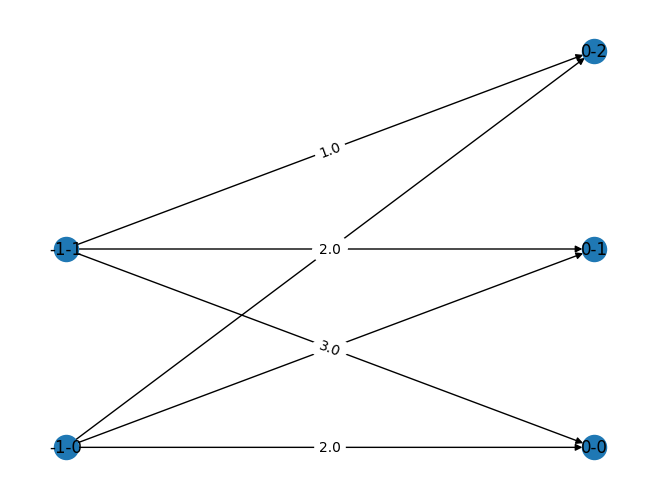


Predicted Data: [[0.6652409557748219, 0.09003057317038045, 0.24472847105479764]]
SSE: 4.0603201288236806e-13
Max SSE: 1e-06
Is SSE less than max SSE? True


In [77]:
model_name = 'test/softmax'

model_factory = ModelFactory(model_name)
model = model_factory.create()
model.summary()
model.draw()
print()

data = [[1.0, 2.0]]
expected_output = [[0.665241, 0.090031, 0.244728]]
trained = model(data)
print(f'Predicted Data: {trained}')

tester.test(expected_output, trained)

#### Kesimpulan

Semua fungsi aktivasi yang telah kami uji berhasil menghasilkan nilai yang diharapkan, yaitu di bawah nilai SSE_MAX yang telah ditetapkan. Fungsi aktivasi yang paling baik adalah fungsi aktivasi Relu karena memiliki nilai akurasi yang paling tinggi dengan penilaian SSE. 

## Perbandingan Dengan Perhitungan Manual

Semua perhitungan terdapat di [Google Sheets](https://docs.google.com/spreadsheets/d/1oL4xwHmo1vg2l9TfZALkG3r50B6X6OfhrNQb0RehOXE/edit?usp=sharing)

#### Relu

![img](https://media.discordapp.net/attachments/1093487471016300545/1093487491287367752/image.png?width=562&height=228)

#### Sigmoid
![img](https://media.discordapp.net/attachments/1093487471016300545/1093487950131642478/image.png?width=558&height=218)

#### Linear
![img](https://media.discordapp.net/attachments/1093487471016300545/1093488338968784926/image.png?width=567&height=216)

#### MultiLayer
![img](https://media.discordapp.net/attachments/1093487471016300545/1093488115081031731/image.png?width=359&height=699)

#### Softmax
![img](https://media.discordapp.net/attachments/1093487471016300545/1093488157779054693/image.png?width=559&height=245)

#### Kesimpulan
Model yang kami hasilkan memiliki nilai yang sama atau mendekati dengan hasil perhitungan manual. Apabila terdapat perbedaan, perbedaan tersebut dapat disebabkan dari pembulatan nilai serta penggunaan kalkulasi menggunakan float. Perbedaan nilai yang kami dapatkan juga tidak berbeda jauh dibandingkan nilai ekspektasi yang telah ditetapkan asisten sebelumnya

## Pembagian Tugas 

1. 13520039 - External Model Reader 
1. 13520054 - Docs and Testing 
1. 13520103 - Structure and Base Class
1. 13520105 - Activation and Inference 